# SWF008-T1 test: EoR power spectrum estimation

This notebook is an example of the test case for SWF-008. The test is described in more details at https://confluence.skatelescope.org/pages/viewpage.action?pageId=319987896. Mainly, it takes two elements of the data provided in the context of the 3d SKA data challenge, part b: a simulated image (IM1) and its cylindrical power spectrum (PS3). In this notebook, one loads the image data, computes its power spectrum with the `ps_eor` package (https://gitlab.com/flomertens/ps_eor/), as done by the SDC3b team, and compare the output to PS3.

Note that IM1, PS3 and the PSF used for the computation must be downloaded. This can be done at the following links:
- IM1 and PS3 as part of the SKA SDC3b dataset @ https://drive.google.com/drive/folders/16S9w444OuOct2rM4PlHwZqUXZMOnmXgt?usp=drive_link (files `IM1.msn_image.fits` and `Pk_PS3_166.0_180.9.txt`) 
- The PSF of the test dataset of SDC3a @ https://drive.google.com/drive/folders/1acIWVwGG8_aLqHKoLJvDCkJu2pcesgH6?usp=sharing (files TestDataset.msn_psf.fits).

In [ ]:
# import required packages
import numpy as np
from astropy.io import fits
from astropy import cosmology, units, constants
import astropy.cosmology.units as cunits
import warnings
import time
import os
import matplotlib.pyplot as plt
from matplotlib import rc, colors

from ps_eor import datacube, pspec, psutil

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
datafolder = './'  # where to find the downloaded data

## Useful fonctions

Define two useful functions:
1. `plot_ps2d` to plot the cylindrical power spectrum
2. `cyl_to_sph` to average the cylindrical power spectrum (2D) into a spherical power spectrum (1D)
3. `get_ps_gen_square` to bin the cylindrical power spectrum generated by `ps_eor`

In [4]:
def plot_ps2d(
        pspec_2d, kperp_bins, kpara_bins, dimless=False,
        label=r'P($k_\parallel$,$k_\perp$) [(Jy/beam)$^2$ Mpc$^3$]',
        norm=None, title=None, cmap='viridis', ax=None,
    ):
    """
    Method to plot cylindrical power spectrum with logarithmic colorbar.

    Parameters
    ----------
        pspec_2d: 2D array of floats
            Array containing the cylindrical power spectrum.
            Shape: (nkperp, nkpara).
        kperp_bins: array of floats
            Array containing the k_perpendicular bins used
            to compute the cylindrical power spectrum.
            Size: nkperp.
        kpara_bins: array of floats
            Array containing the k_parallel bins used
            to compute the cylindrical power spectrum.
            Size: nkpara.  
        dimless: boolean
            Whether the power spectrum is dimensionless or not.
            Default: False.
        label: str
            Label for the colorbar.
            Default is P(k) in (Jy/beam)2 Mpc3.
        norm: matplotlib.colors.Normalize object.
        title: str
            Title for the axis.
            Default is None.
        cmap: str
            Matplotlib colormap to use.
            Default is viridis.
        ax: matplotlib.axes object
            Axis to plot the figure on.
            Default is None (new figure and axis are generated).


    """

    kperp_bins = np.atleast_1d(kperp_bins)
    kpara_bins = np.atleast_1d(kpara_bins)
    assert np.shape(pspec_2d) == (kperp_bins.size, kpara_bins.size), \
        "Input pspec must have shape (kperp_bins.size, kpara_bins.size)."
    if np.any(pspec_2d < 0):
        warnings.warn(
            'There are negative values in your pspec. '
            'Absolute value will be used for the figure.'
        )
        pspec_2d = np.abs(pspec_2d)

    existing_axis = True
    if ax is None:
        fig, ax = plt.subplots(1, 1,)
        existing_axis = False
    if dimless:
        k = np.sqrt(kperp_bins[None, :]**2 + kpara_bins[:, None]**2)
        pspec2d *= k**3 *1./2./np.pi**2
        label = r'$\Delta^2(k)$ [K$^2$]'

    im = ax.pcolor(
        kperp_bins,
        kpara_bins,
        pspec_2d,
        shading='auto',
        cmap=cmap,
        norm=norm,
    )
    if not existing_axis:
        plt.colorbar(im, label=label, ax=ax)
        ax.set_ylabel(r'k$_\parallel$ [Mpc$^{-1}]$')
        ax.set_xlabel(r'k$_\perp$ [Mpc$^{-1}]$')
    if title is not None:
        ax.set_title(title)

In [5]:
def cyl_to_sph(cyl_ps, kperp_bins, kpara_bins, kbins=None, nbins=None):
    """
    Compute spherical power spectrum from cylindrical one.

    Parameters
    ----------
        ps_data: 2D array of floats
            2D cylindrical power spectrum.
        kperp_bins: array of floats
            kperp cylindrical bins used to obtain
            ps_data.
        kpara_bins: array of floats
            kpara cylindrical bins used to obtain
            ps_data.
        kbins: array or list of floats
            Spherical k-bins to use.
            Units should be Mpc-1.
            All values should be positive.
            Default is None.
        nbins: int
            Number of bins to use when building the spherical power
            spectrum. Set to kbins.size if kbins is fed.
            Default is 30.
    Returns
    -------
        kbins: array of floats
            Spherical k-bins used, weighted by cell population.
        pspec: array of floats
            Spherical power spectrum in units of mK2 Mpc^3.

    """
    # check dimensions
    assert np.shape(cyl_ps) == (kperp_bins.size, kpara_bins.size), \
        "Shapes of ps_data and of kperp and kpara bins do not match."

    k_mag = np.sqrt(kperp_bins[:, None]**2 + kpara_bins[None, :]**2)

    # define the spherical bins and bin edges
    if kbins is None:
        if nbins is None:
            nbins = 10
        else:
            nbins = int(nbins)
        kmin = np.min(k_mag) * 2.
        kmax = np.max(k_mag) / 2.
        bin_edges = np.histogram_bin_edges(
            np.sort(k_mag.flatten()),
            bins=nbins,
            range=(kmin, kmax)
        )
    else:
        dk = np.diff(kbins).mean()
        assert dk > 0
        bin_edges = np.arange(kbins.min()-dk/2, kbins.max()+dk, dk)
        assert np.size(bin_edges) == np.size(kbins) + 1
        nbins = kbins.size
    assert np.size(bin_edges) > 1, "Error obtaining kpar bins."

    pspec = np.zeros(len(bin_edges) - 1)
    weighted_k = np.zeros(len(bin_edges) - 1)
    for k in range(len(bin_edges) - 1):
        mask = (bin_edges[k] < k_mag) & (k_mag <= bin_edges[k + 1])
        if mask.any():
            pspec[k] = np.mean(cyl_ps[mask].real)  # [mk^2 Mpc^3]
            weighted_k[k] = np.mean(k_mag[mask])
    # Make sure there are no nans! If there are make them zeros.
    pspec[np.isnan(pspec)] = 0.0
    # Check empty bins
    if np.any(weighted_k == 0.):
        print('Some empty k-bins!')

    return weighted_k, pspec

In [6]:
def get_ps_gen_square(cube, fmin, **kargs):
    ''' This function return a ps_gen object which will return a power-spectra with the SDC3a binning scheme '''
    z = psutil.freq_to_z((fmin + 7.5) * 1e6)
    du = psutil.k_to_l(0.05, z) / (2 * np.pi)
    umin = du / 2.
    umax = psutil.k_to_l(0.5, z) / (2 * np.pi) + du / 2
    M = int((1 / psutil.k_to_delay(0.05, z)) / 0.1e6)
    ps_builder = pspec.PowerSpectraBuilder()
    ps_gen = ps_builder.get(cube, fmhz_range=[fmin, fmin + 15], du=du, umin=umin, umax=umax, uniform_u_bins=True, **kargs)
    ps_gen.eor.M = M
    ps_gen._compute_delays()
    return ps_gen

def set_kpar_max(ps2d, kpar_max=0.53):
    idx = ps2d.k_par < kpar_max
    return pspec.CylindricalPowerSpectra(ps2d.data[idx], ps2d.err[idx], ps2d.delay[idx], ps2d.el, ps2d.k_per, 
                                         ps2d.k_par[idx], n_eff=ps2d.n_eff[idx])

## General parameters

These are general parameters describing the dataset and the instrument (e.g., integration time, k-bins, station diameter).

In [7]:
# 21cm rest-frame frequency
nu0 = 1420 * units.MHz

In [8]:
# BINS TO USE FOR HISTOGRAMMING
# Must have been previously dowloaded (see links above)

# k-range
dkperp = 0.05
kperp_bins = np.arange(0.05, 0.55, step=dkperp)
kperp_edges = np.arange(kperp_bins.min()-dkperp/2, kperp_bins.max()+dkperp, dkperp)

dkpara = 0.05
kpara_bins = np.arange(0.05, 0.55, step=dkperp)
kpara_edges = np.arange(kpara_bins.min()-dkpara/2, kpara_bins.max()+dkpara, dkpara)


k_mag = np.sqrt(kperp_bins[:, None]**2 + kpara_bins[None, :]**2)
kmin = np.min(k_mag) / units.Mpc
kmax = np.max(k_mag) / units.Mpc
krange = np.linspace(kmin, kmax, 10).value

In [9]:
# instrument specs
bmax = 5. * units.km  # maximum baseline
D_station = (35+40)/2 * units.m  # SKA-Low station diameter

In [10]:
# details about mock observations
total_time = 1000. * units.hour  # total observation time
int_time = 10.*units.second  # integration time

## Load data cubes from FITS files

We choose a limited spectral window to reduce computations:

In [11]:
df = 0.100  # MHz, frequency resolution
fmin = 166.0  # minimum frequency on the spectral window
fmax = 180.9  # maximum frequency on the spectral window
spw_range = np.round(np.arange(fmin, fmax+df, step=df), decimals=2) * units.MHz  # spectral window
avg_nu = np.mean(spw_range)  # mean frequency over spectral window
avg_z = nu0/avg_nu - 1.  # mean redshift over spectral window
lamb_array = constants.c.si / (spw_range.si)  # array of observed wavelengths over spectral window

Below, we extract the required frequency channels from the input files and save the result as a new fits file which will be fed to `ps_eor`.

In [12]:
def reduce_file(filename, spw_range):
    """
    Method to select given frequency channels in FITS file.

    Parameters
    ----------
        filename: str
            Path to the FITS files containing the image data (3D).
            Should have units (astropy.units).
        spw_range: array of floats
            List of frequencies to extract from dataset.
    
    Returns
    ------
        hdu
    """
    nf = spw_range.size
    hdu = fits.open(filename)
    nfreqs = hdu[0].header['NAXIS3']
    df = hdu[0].header['CDELT3'] * units.Hz
    fmin = hdu[0].header['CRVAL3'] * units.Hz
    fmax = fmin + df * nfreqs
    freqs = np.arange(fmin.value, fmax.value, step=df.value) * units.Hz
    assert fmin <= spw_range[0].to(units.Hz)
    assert fmax >= spw_range[-1].to(units.Hz)
    assert freqs.size == nfreqs
    inds = np.where((freqs<=spw_range[-1]) & (freqs>=spw_range[0]))[0]
    assert inds.size == nf
    hdu[0].data = hdu[0].data[inds, :, :]
    hdu[0].header['NAXIS3'] = nf
    hdu[0].header['CRVAL3'] = spw_range[0].to(units.Hz).value
    return hdu

In [13]:
# REDUCING FILES
weighting = 'msn'

# PSF
reduced_psf_file = f'{datafolder}TestDataset.{weighting}_psf_reduced.fits'
if os.path.exists(reduced_psf_file):
    # If the reduced file exist, make sure it contains the appropriate frequencies.
    hdu = fits.open(reduced_psf_file)
    du = abs(hdu[0].header['CDELT1'])
    assert hdu[0].data.shape[0] == spw_range.size
    hdu.close()
else:
    # Else, load full PSF file and reduce
    psffile = f'{datafolder}TestDataset.{weighting}_psf.fits'
    hdu = reduce_file(psffile, spw_range)
    du = abs(hdu[0].header['CDELT1'])
    npix = hdu[0].data.shape[1]
    # Save to new file
    hdu.writeto(reduced_psf_file, overwrite=True)
    hdu.close()

# IMAGE
reduced_image_file = f'{datafolder}IM1.{weighting}_image_reduced.fits'
if os.path.exists(reduced_image_file):
    # If the reduced file exist, make sure it contains the appropriate frequencies.
    hdu = fits.open(reduced_image_file)
    assert hdu[0].data.shape[0] == spw_range.size
    hdu.close()
else:
    # Else, load full image file and reduce.
    imagefile = f'{datafolder}IM1.{weighting}_image.fits' # location of the image file downloaded from SKA SDC3 drive
    hdu = reduce_file(imagefile, spw_range)
    hdu.writeto(reduced_image_file, overwrite=True)
hdu.close()

We use `ps_eor` to load the reduced PSF and image files and transform them into visibility cubes:

In [ ]:
t0 = time.time()
w_cube = datacube.CartWeightCube.load_from_fits_image_and_psf(
    files=[f'IM1.{weighting}_image_reduced.fits'],
    files_psf=[f'TestDataset.{weighting}_psf_reduced.fits'],
    umin=30,#max(50, D_station/np.mean(lamb_array)),  # 50 default
    umax=500,#min(250, bmax.si/np.mean(lamb_array)),  # 250 default
    theta_fov=np.radians(9.10),#(1.22*np.mean(lamb_array)/D_station).value,
    int_time=int_time.to(units.s).value,
    total_time=total_time.to(units.s).value,
    use_wscnormf=False, # use pSF and not WSCNORMF to normalise the visibilities
    window_function=datacube.WindowFunction('hann') # or datacube.WindowFunction(('tukey', 0.2))
)
t1 = time.time()
print(f'Conversion to visibility cube took {(t1-t0)/60.:.2f} minutes.')

 Progress: 1 / 1 (Total: 0.00 s) 
 Progress: 1 / 1 (Total: 0.01 s) 
Filtering 0 modes (0.00 %)


## Power spectra

A cosmological model is required to move from observational to cosmological space:

In [17]:
cos = cosmology.FlatLambdaCDM(Om0=0.30964, H0=67.66)  # Planck 2018 cosmology used in SDC3b

1. Read from file

Here, we load and plot the reference power spectrum, given by SDC3b team as the power spectrum  of IM1 above, and which we want to recover from IM1.

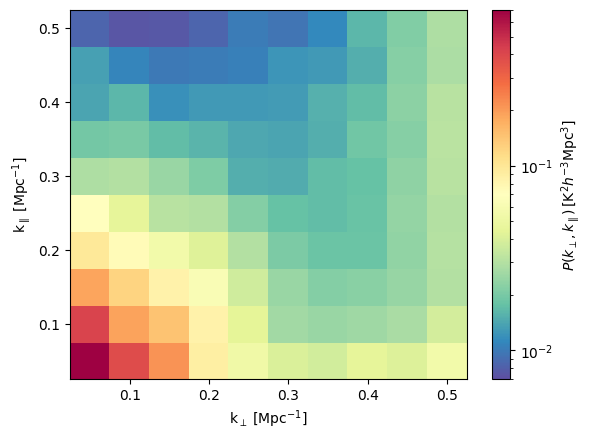

In [33]:
# load PS3 from file
datafile = f'{datafolder}Pk_PS3_{spw_range[0].to(units.MHz).value:.1f}_{spw_range[-1].to(units.MHz).value:.1f}.txt'
# specify units
pspec_2d_from_file = np.loadtxt(datafile) * units.K**2 * units.Mpc**3 / cunits.littleh**3
# plot results
vmin = 7e-3
vmax = 7e-1
plot_ps2d(
        pspec_2d_from_file, 
        kperp_bins, kpara_bins,
        cmap='Spectral_r', norm=colors.LogNorm(vmin=vmin, vmax=vmax),
        label=r'$P(k_\perp, k_\parallel)\, [\mathrm{K}^2 h^{-3} \mathrm{Mpc}^3]$'
)

2. Computed from the image

Here, we compute the power spectrum from the image cube IM1 and the PSF with `ps_eor`.

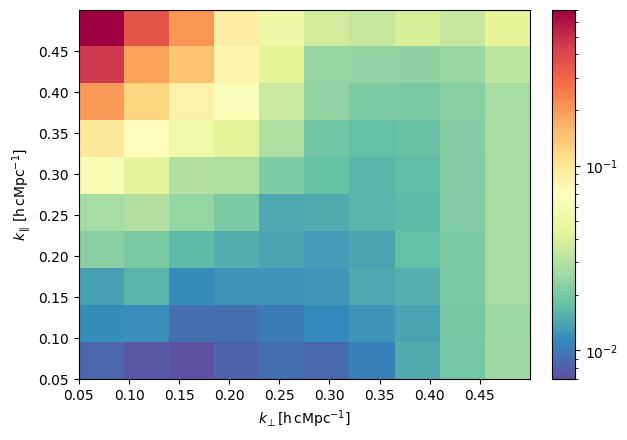

In [27]:
# Create a Cylindrically averaged PS and plot
ps_gen_sq = get_ps_gen_square(w_cube, fmin, primary_beam='ska_low', window_fct='hann')
ps2d = set_kpar_max(ps_gen_sq.get_ps2d(w_cube))

fig, ax = plt.subplots()
ps2d.plot(ax=ax, vmin=vmin, vmax=vmax, cmap='Spectral_r')

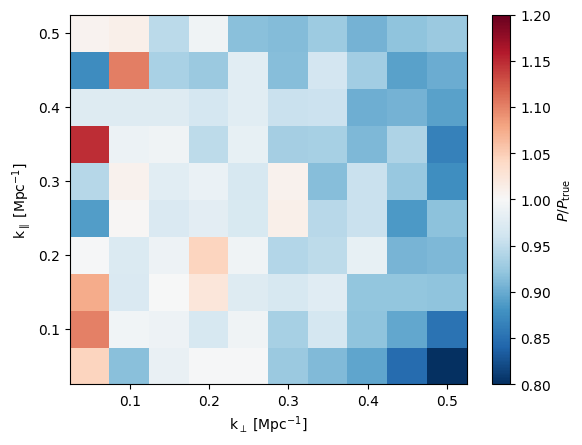

In [34]:
plot_ps2d(
        ps2d.data/pspec_2d_from_file, 
        kperp_bins, kpara_bins,
        cmap='RdBu_r', norm=colors.Normalize(vmin=0.8, vmax=1.2),
        label=r'$P/P_\mathrm{true}$'
)

### Compare power spectra

Below, we compare the power spectrum obtained from the image to the expected result, PS3, in spherical space:

In [24]:
nbins = 10
kbins = np.linspace(np.min(k_mag), np.max(k_mag), nbins)
dk= np.diff(kbins)[0]
kbin_edges = np.arange(kbins.min()-dk/2, kbins.max()+dk, dk)

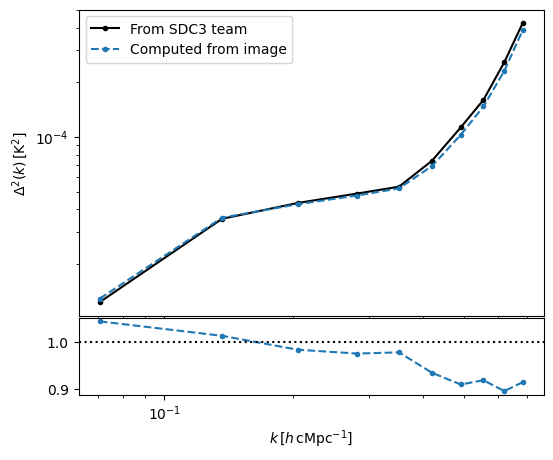

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios':(4, 1), 'hspace':0.01})

# Average input cynlindrical ps
w_kbins, pspec_1d_from_file = cyl_to_sph(pspec_2d_from_file.value, kperp_bins, kpara_bins, kbins=kbins)
axes[0].loglog(w_kbins, w_kbins**3 * pspec_1d_from_file / 2./ np.pi**2, color='k', label='From SDC3 team', marker='.')

# Average output cynlindrical ps
w_kbins, pspec_1d_from_image = cyl_to_sph(ps2d.data, kperp_bins, kpara_bins, kbins=kbins)
axes[0].loglog(w_kbins, w_kbins**3 * pspec_1d_from_image / 2./ np.pi**2, label='Computed from image', marker='.', ls='--')
axes[1].plot(w_kbins, pspec_1d_from_image/pspec_1d_from_file, marker='.', ls='--')

axes[1].axhline(1, color='k', ls=':')
axes[0].legend()
axes[0].set_ylabel(r'$\Delta^2 (k)\,[\mathrm{K}^2]$')
axes[1].set_xlabel(r'$k\,[h\,\mathrm{cMpc^{-1}}]$')
fig.savefig('output_spherical_ps.png', dpi=220)